Importing Libraries

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from prophet import Prophet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib


Importing Processed Data

In [3]:
data=pd.read_csv('Merged Data.csv')

data.head()

,timestamp,Basel Precipitation Total,Basel Cloud Cover Total,Basel Shortwave Radiation,Basel Longwave Radiation,Basel UV Radiation,P,H_sun,T2m,WS10m
0,2005-01-01 00:00:00,0.2,96.0,0.0,328.0,0.0,0.0,0.0,2.44,1.86
1,2005-01-01 01:00:00,0.2,100.0,0.0,329.0,0.0,0.0,0.0,2.56,1.86
2,2005-01-01 02:00:00,0.0,100.0,0.0,328.0,0.0,0.0,0.0,2.58,1.79
3,2005-01-01 03:00:00,0.0,100.0,0.0,326.0,0.0,0.0,0.0,2.53,1.72
4,2005-01-01 04:00:00,0.1,100.0,0.0,325.0,0.0,0.0,0.0,2.48,1.66


timestamps str---->datetime

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

heatmap 

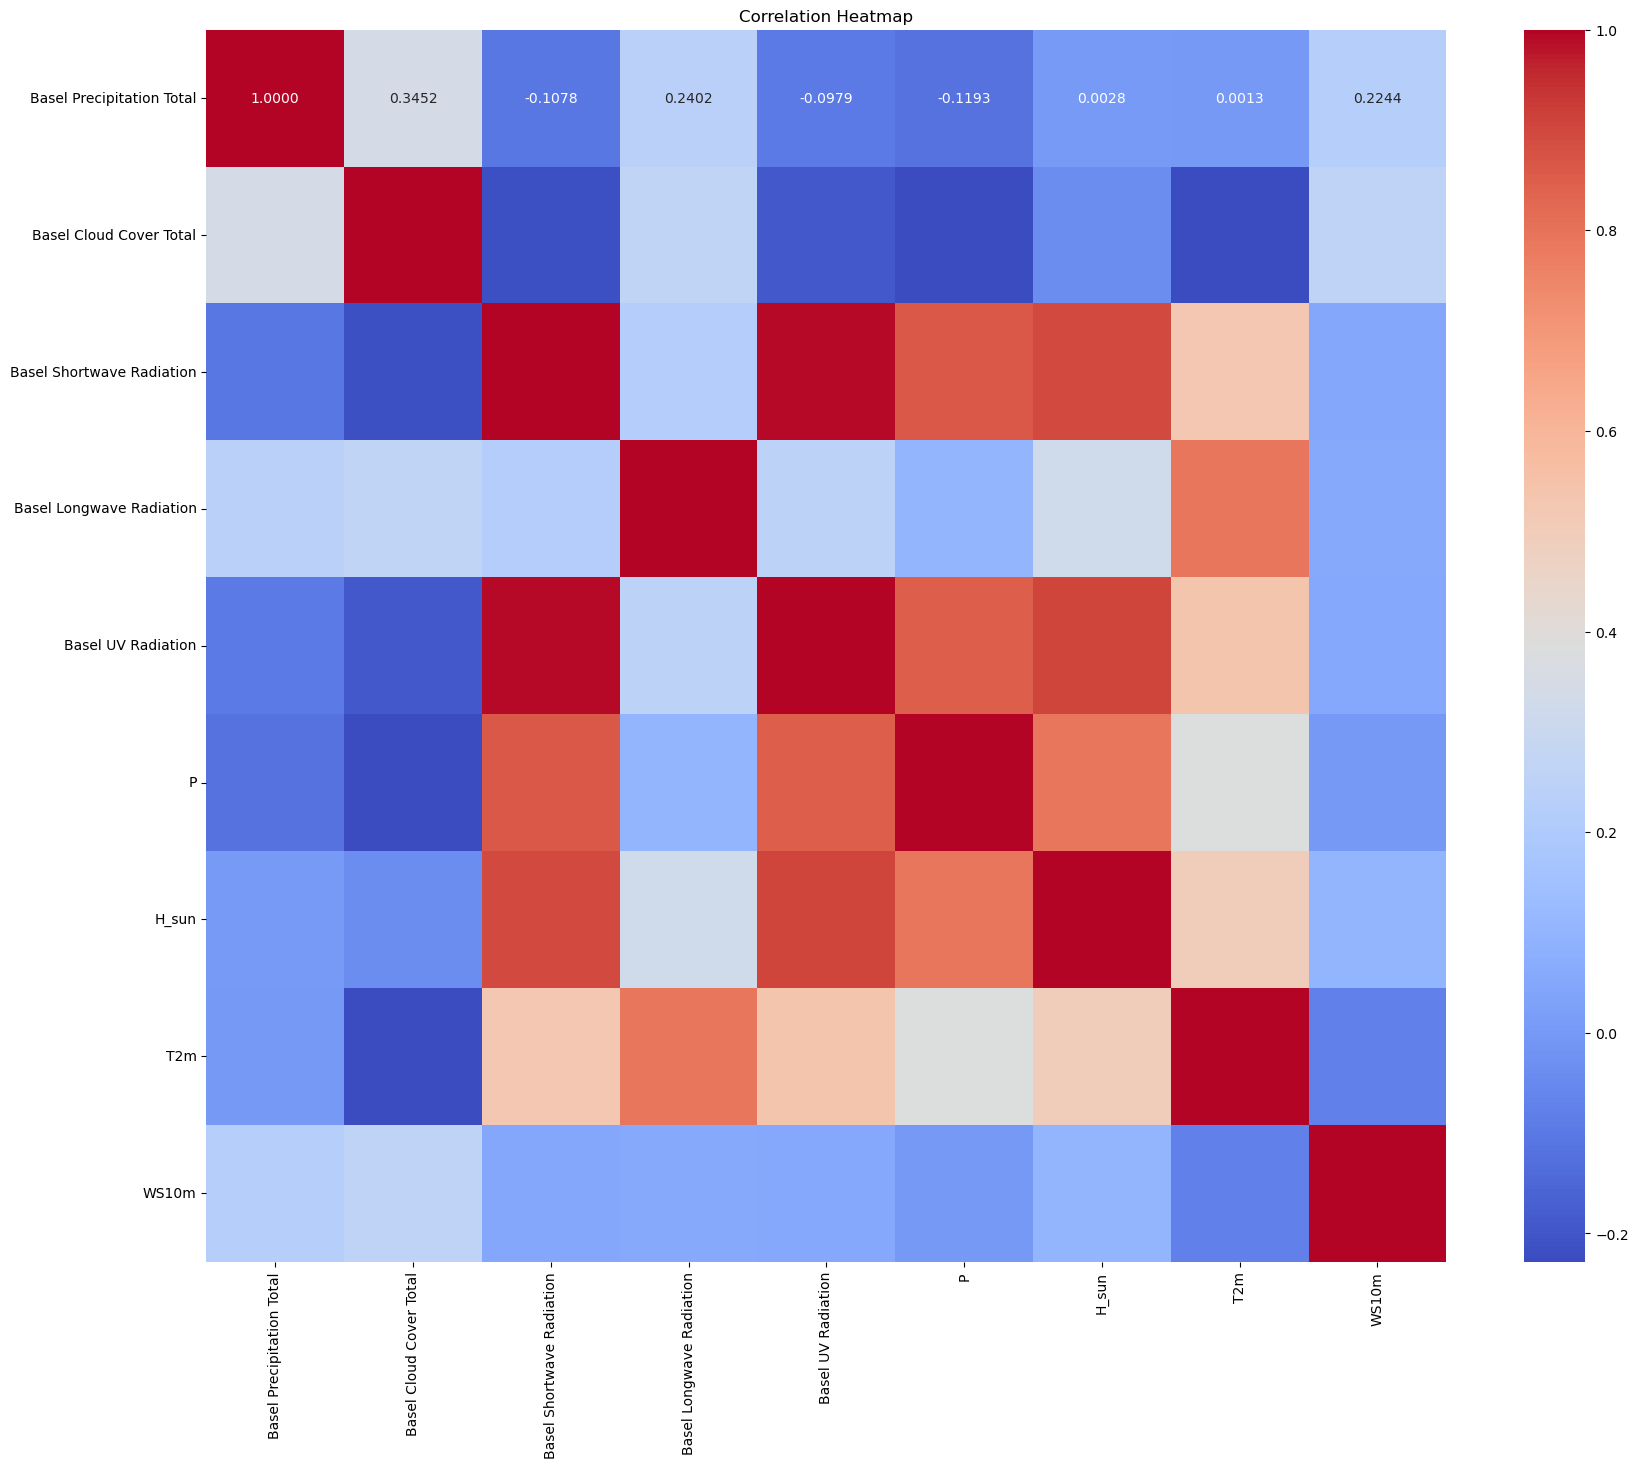

In [5]:
dataheatmap=data.drop(columns=['timestamp'])
# Compute correlation matrix
corr = dataheatmap.corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Heatmap')
plt.show()

Visualisations

In [6]:
data_avg = pd.DataFrame()
data_avg['timestamp']=data['timestamp'].copy()

In [7]:
# Calculate rolling average with a window of 720 (30 days)
data_avg['Monthly_Avg'] = data['P'].rolling(window=720).mean()

# Calculate rolling average with a window of 8,640 (1 year) to see if there is a yearly trend
data_avg['Year_Avg'] = data['P'].rolling(window=8640).mean()

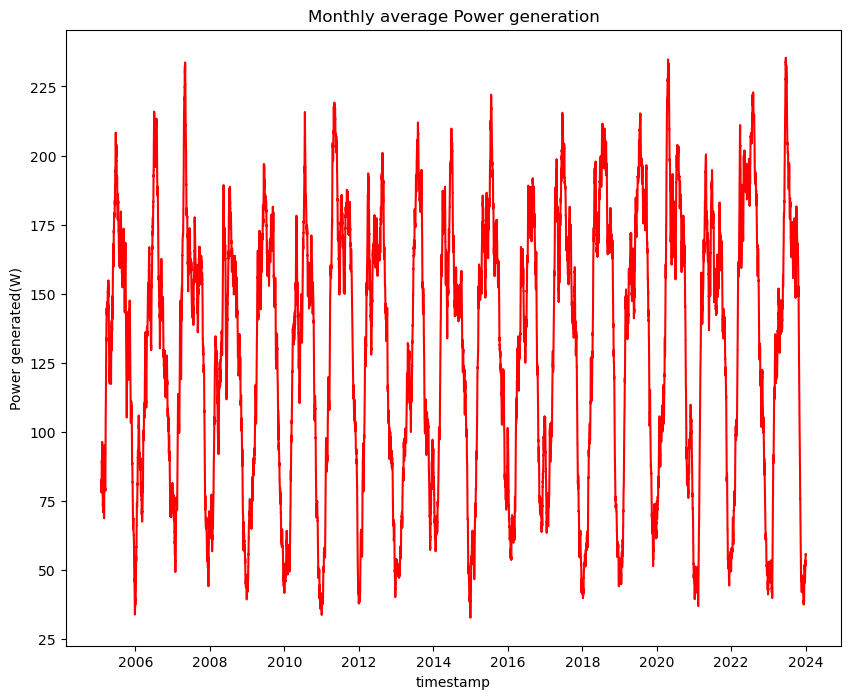

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(data_avg['timestamp'], data_avg['Monthly_Avg'], color='red', label='Monthly Average')
plt.title('Monthly average Power generation')
plt.xlabel('timestamp')
plt.ylabel('Power generated(W)')

plt.show()

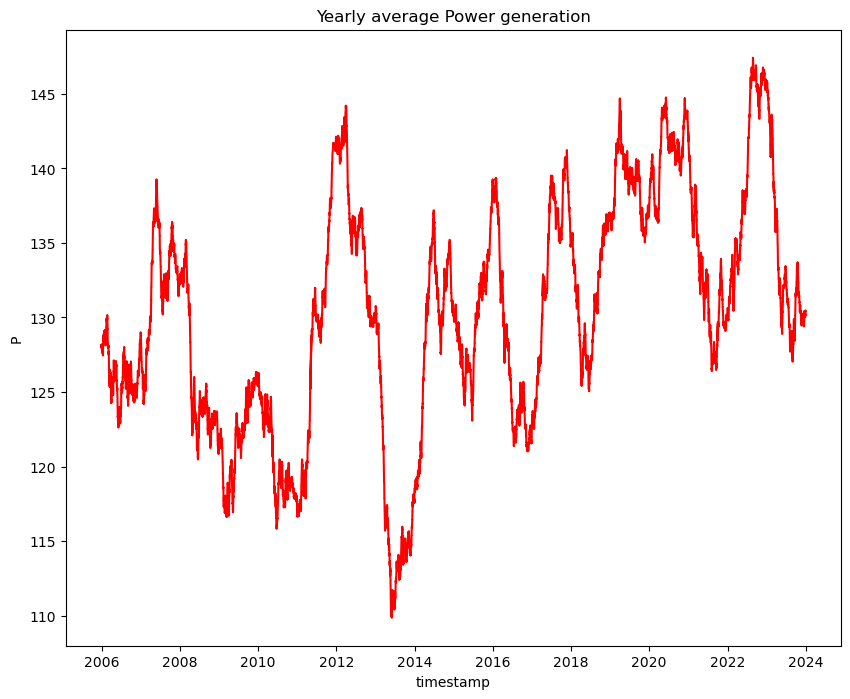

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(data_avg['timestamp'], data_avg['Year_Avg'], color='red', label='Yearly Average')
plt.title('Yearly average Power generation')
plt.xlabel('timestamp')
plt.ylabel('P')

plt.show()

Seasonal Paterns

In [10]:
data['hour']=data['timestamp'].dt.hour
data['day']=data['timestamp'].dt.dayofyear
data['month']=data['timestamp'].dt.month  

In [11]:
hourly_avg = data.groupby('hour')['P'].mean()
monthly_avg = data.groupby('month')['P'].mean()


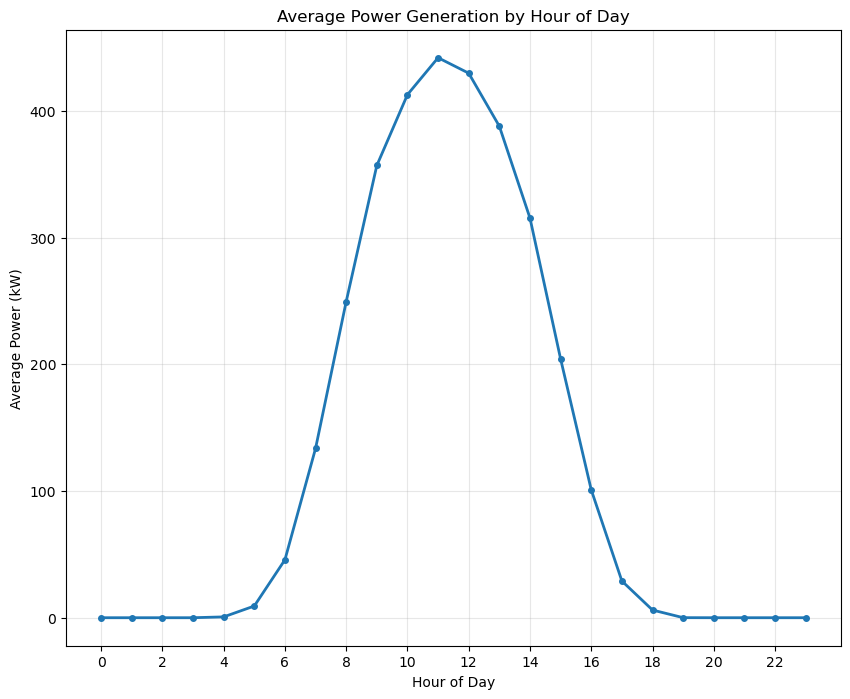

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=4)
plt.title('Average Power Generation by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.show()

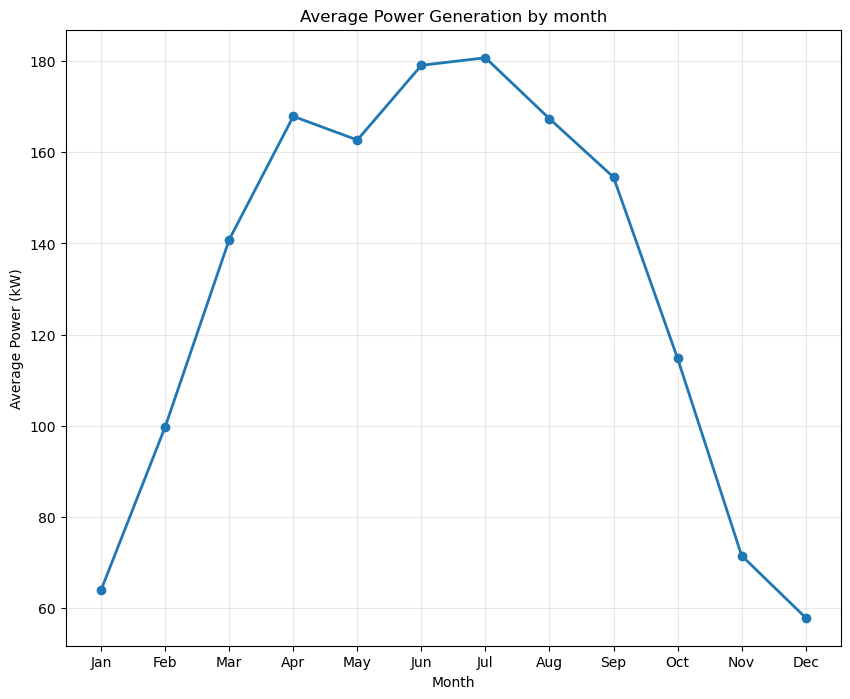

In [13]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(10, 8))
plt.plot(month_names, monthly_avg.values, marker='o', linewidth=2)
plt.title('Average Power Generation by month')
plt.xlabel('Month')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 12, 1))
plt.show()

In [14]:
#making a temperature column with int values
data["temperature1.0"] = data["T2m"].astype(int)



In [15]:
average_by_temp=data.groupby('temperature1.0')['P'].mean()
average_by_temp.head()

temperature1.0
-18     1.020000
-17    39.743333
-16    61.281304
-15    49.628519
-14    50.773600
Name: P, dtype: float64

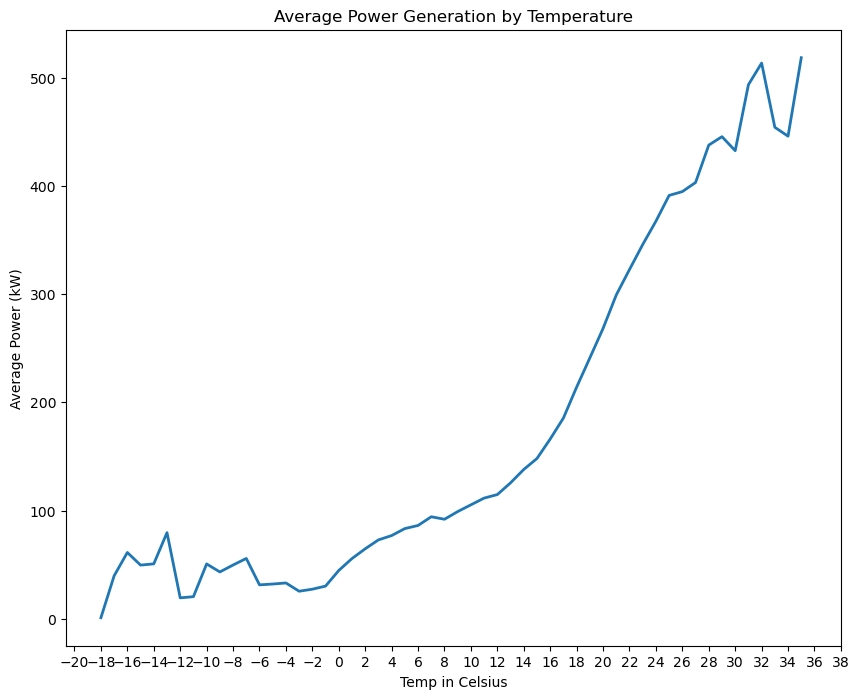

In [16]:
plt.figure(figsize=(10,8))
plt.plot(average_by_temp.index,average_by_temp.values,  marker='', linewidth=2)
plt.title('Average Power Generation by Temperature')
plt.xlabel('Temp in Celsius')
plt.xticks(range(-20, 40, 2))
plt.ylabel('Average Power (kW)')
plt.show()


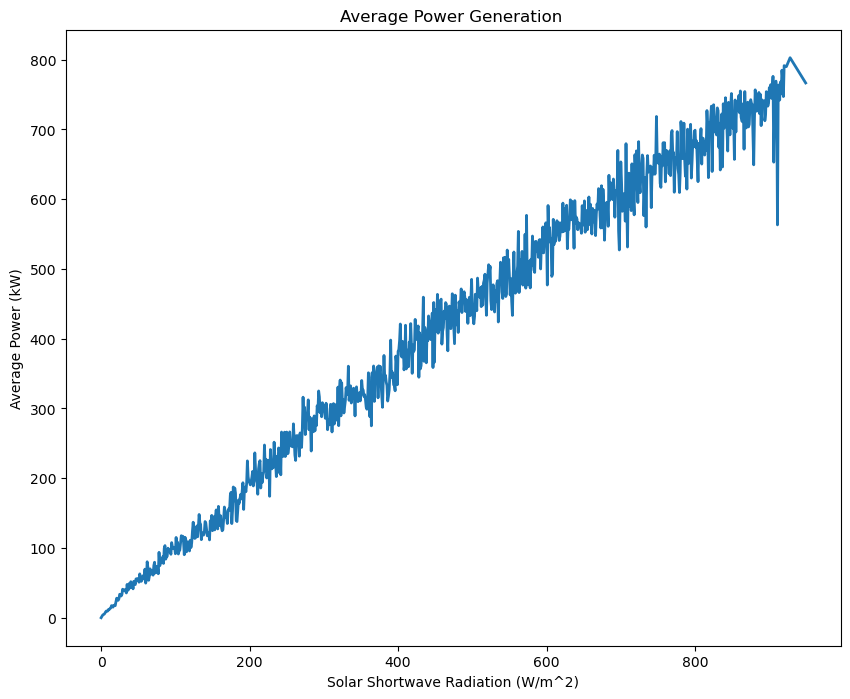

In [17]:
#solar irradiation effect on power generation
Irradition_power=data.groupby('Basel Shortwave Radiation')['P'].mean( )

plt.figure(figsize=(10,8))
plt.plot(Irradition_power.index,Irradition_power.values,  marker='', linewidth=2)
plt.title('Average Power Generation ')
plt.xlabel('Solar Shortwave Radiation (W/m^2)')
plt.ylabel('Average Power (kW)')
plt.show()


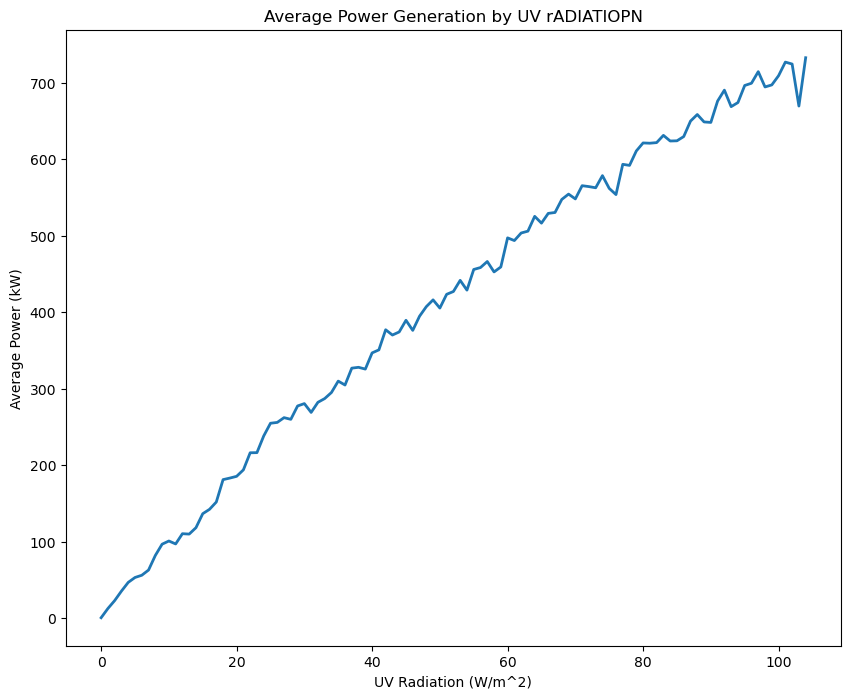

In [18]:
#making a UV Radiation column with int values
data["UV1.0"] = data["Basel UV Radiation"].astype(int)

average_by_UV=data.groupby('UV1.0')['P'].mean()
average_by_UV.tail()

# Plotting the average power generation by UV radiation
plt.figure(figsize=(10,8))
plt.plot(average_by_UV.index,average_by_UV.values,  marker='', linewidth=2)
plt.title('Average Power Generation by UV rADIATIOPN')
plt.xlabel('UV Radiation (W/m^2)')
plt.ylabel('Average Power (kW)')
plt.show()


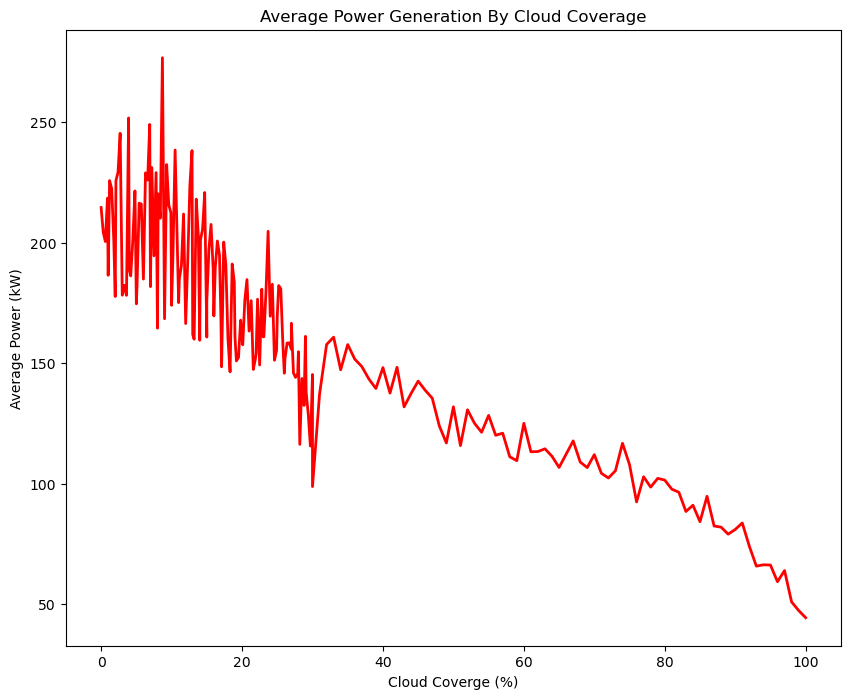

In [19]:
CloudCoverage_power=data.groupby('Basel Cloud Cover Total')['P'].mean( )

plt.figure(figsize=(10,8))
plt.plot(CloudCoverage_power.index,CloudCoverage_power.values, color='r', marker='', linewidth=2)
plt.title('Average Power Generation By Cloud Coverage')
plt.xlabel('Cloud Coverge (%)')

plt.ylabel('Average Power (kW)')
plt.show()


In [20]:
print(data.columns)

Index(['timestamp', 'Basel Precipitation Total', 'Basel Cloud Cover Total',
       'Basel Shortwave Radiation', 'Basel Longwave Radiation',
       'Basel UV Radiation', 'P', 'H_sun', 'T2m', 'WS10m', 'hour', 'day',
       'month', 'temperature1.0', 'UV1.0'],
      dtype='object')


In [21]:
data.drop(columns=['temperature1.0', 'UV1.0'], inplace=True)

In [22]:
print(data.columns)

Index(['timestamp', 'Basel Precipitation Total', 'Basel Cloud Cover Total',
       'Basel Shortwave Radiation', 'Basel Longwave Radiation',
       'Basel UV Radiation', 'P', 'H_sun', 'T2m', 'WS10m', 'hour', 'day',
       'month'],
      dtype='object')


Building And Training the Model

In [26]:
# Prepare features for LightGBM
lgb_features = [ 'Basel Precipitation Total', 'Basel Cloud Cover Total',
       'Basel Shortwave Radiation', 'Basel Longwave Radiation',
       'Basel UV Radiation', 'H_sun', 'T2m', 'WS10m', 'hour', 'day',
       'month']


In [27]:

df_clean = data.dropna()

# Sort by time just to be safe
df_clean = df_clean.sort_values('timestamp').reset_index(drop=True)

In [28]:
# Split data
train_size = int(0.8 * len(df_clean))
X_train = df_clean[lgb_features][:train_size]
y_train = df_clean['P'][:train_size]
X_test= df_clean[lgb_features][train_size:]
y_test= df_clean['P'][train_size:]


In [56]:
print("Training LightGBM model...")
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}


Training LightGBM model...


In [57]:
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)


c:\Users\MSI\anaconda3\Lib\site-packages\lightgbm\callback.py:347: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


In [58]:
# Make predictions
lgb_predictions = lgb_model.predict(X_test)

In [59]:
# Calculate LightGBM metrics
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
lgb_r2 = r2_score(y_test, lgb_predictions)

print(f"LightGBM MAE: {lgb_mae:.4f}")
print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"LightGBM R²: {lgb_r2:.4f}")


LightGBM MAE: 38.1223
LightGBM RMSE: 85.4354
LightGBM R²: 0.8583


In [60]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': lgb_model.feature_name(),
    'importance': lgb_model.feature_importance()
}).sort_values('importance', ascending=False)
print(f"\nTop 5 most important features:")
print(feature_importance.head())


Top 5 most important features:
                     feature  importance
1    Basel_Cloud_Cover_Total        4203
9                        day        4038
2  Basel_Shortwave_Radiation        3593
6                        T2m        3567
3   Basel_Longwave_Radiation        3298


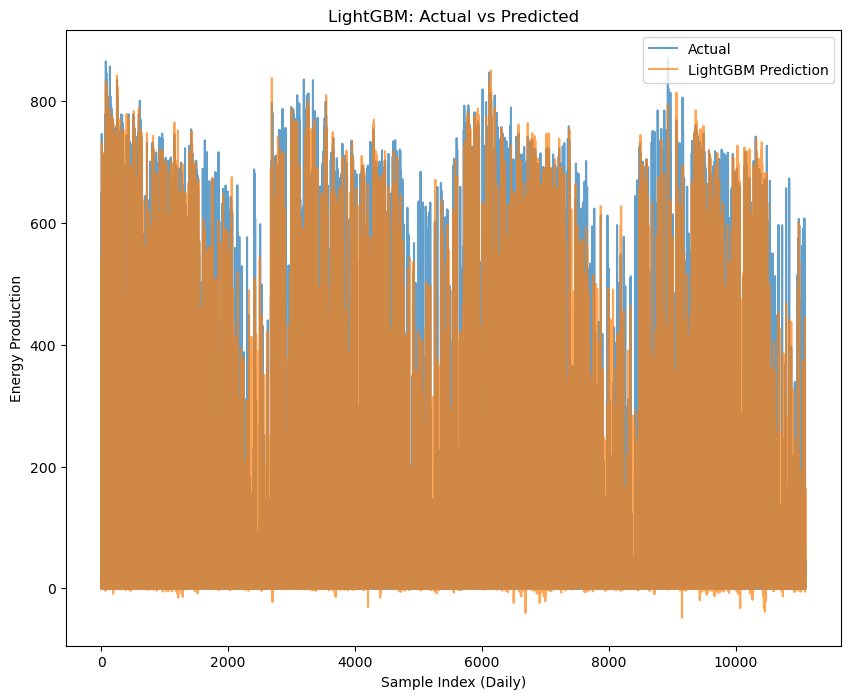

In [63]:
plt.figure(figsize=(10, 8))

test_sample_indices = range(0, len(y_test),3)  # Sample daily
plt.plot([y_test.iloc[i] for i in test_sample_indices], label='Actual', alpha=0.7)
plt.plot([lgb_predictions[i] for i in test_sample_indices], label='LightGBM Prediction', alpha=0.7)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Sample Index (Daily)')
plt.ylabel('Energy Production')
plt.legend()


Saving the model

In [64]:
import pickle

with open('solar_energy_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

Save feature names for the Streamlit app

In [65]:
import joblib
joblib.dump(lgb_features, 'feature_names.pkl')
print("✅ Feature names saved as 'feature_names.pkl'")

✅ Feature names saved as 'feature_names.pkl'


In [66]:
print(X_train.columns)

Index(['Basel Precipitation Total', 'Basel Cloud Cover Total',
       'Basel Shortwave Radiation', 'Basel Longwave Radiation',
       'Basel UV Radiation', 'H_sun', 'T2m', 'WS10m', 'hour', 'day', 'month'],
      dtype='object')


In [67]:
new_data = pd.DataFrame([[0.0,	11.700001,	532.0,	278.0,	57.67,	30.33,	14.19,	1.52,	14,	75,	3]], columns=['Basel Precipitation Total', 'Basel Cloud Cover Total','Basel Shortwave Radiation', 'Basel Longwave Radiation','Basel UV Radiation', 'H_sun', 'T2m', 'WS10m', 'hour', 'day','month'])

In [77]:
X_test.iloc[1000]

Basel Precipitation Total      0.00
Basel Cloud Cover Total       28.00
Basel Shortwave Radiation      0.00
Basel Longwave Radiation     323.00
Basel UV Radiation             0.00
H_sun                          0.00
T2m                           15.33
WS10m                          1.24
hour                          20.00
day                          115.00
month                          4.00
Name: 134228, dtype: float64

In [72]:
prediction = lgb_model.predict(X_test.iloc[8])
print("Prediction:", prediction[0])

Prediction: 602.6384274054338


In [74]:
y_test.iloc[8]

711.48

In [ ]:
data['day']